# Project 1, Part 5, Best Customer Analytics

University of California, Berkeley
Master of Information and Data Science (MIDS) program
w205 - Fundamentals of Data Engineering

Student: Stephanie Cabanela

Year: 2022

Semester: Spring

Section: 7


# Included Modules and Packages

Code cell containing your includes for modules and packages

In [1]:
import math
import numpy as np
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns

# Supporting code

Code cells containing any supporting code, such as connecting to the database, any functions, etc.  Remember you can use any code from the labs.

In [2]:
# Source for this cell: Lab 2

#
# function to run a select query and return rows in a pandas dataframe
# pandas puts all numeric values from postgres to float
# if it will fit in an integer, change it to integer
#

def my_select_query_pandas(query, rollback_before_flag, rollback_after_flag):
    "function to run a select query and return rows in a pandas dataframe"
    
    if rollback_before_flag:
        connection.rollback()
    
    df = pd.read_sql_query(query, connection)
    
    if rollback_after_flag:
        connection.rollback()
    
    # fix the float columns that really should be integers
    
    for column in df:
    
        if df[column].dtype == "float64":

            fraction_flag = False

            for value in df[column].values:
                
                if not np.isnan(value):
                    if value - math.floor(value) != 0:
                        fraction_flag = True

            if not fraction_flag:
                df[column] = df[column].astype('Int64')
    
    return(df)

# Connect to Postgres database
connection = psycopg2.connect(
    user = "postgres",
    password = "ucb",
    host = "postgres",
    port = "5432",
    database = "postgres"
)

# Create a cursor for the connection
cursor = connection.cursor()

## The executives want you to come up with a high level design of a model, in the form of written criteria, to determine who the best customers are. 

## You do NOT have to code the model. 

## You do NOT have to give an actual list of best customers. 

## Create an executive summary explaining your model. You must support your summary with data, in the form of output of queries, data visualization, etc. There is a 1 query minimum.

## Executive Summary: Best Customer Model for AGM
My best customer model for AGM is a variation of the RFM model. The RFM model generally analyzes customer value by looking at three dimensions:
* **R**ecency: How recently did the customer buy?
* **F**requence: How often does the customer buy?
* **M**onetary Value: How much does the customer spend?

### Aggregating the Customer Sales Data
I aggregated the customer sales data into a single table and calculated the recency, frequency, monetary values, and lifetime as follows:
* lifetime = number of days between a customer's first and last sale dates
* Recency = the interval between the last sale and the last day of 2020
* Frequency = the number of sales over a customer's lifetime
* Monetary Value = the total revenue for a customer over his/her/their lifetime

See the aggregated customer data table below:

In [3]:
rollback_before_flag = True
rollback_after_flag = True

query = """

select customer_id,
        min(sale_date) as first_sale_date,
        max(sale_date) as last_sale_date,
        max(sale_date) - min(sale_date) as lifetime,
        '2020-12-31' - max(sale_date) as recency,
        count(distinct(store_id, sale_id)) as frequency,
        sum(total_amount) as monetary_value
from sales
group by customer_id
order by customer_id

"""


aggregated_customer_df = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
aggregated_customer_df

,customer_id,first_sale_date,last_sale_date,lifetime,recency,frequency,monetary_value
0,1,2020-01-02,2020-12-30,363,1,71,5004
1,2,2020-01-01,2020-12-27,361,4,66,4308
2,3,2020-01-02,2020-12-26,359,5,76,3996
3,4,2020-01-16,2020-12-31,350,0,58,3456
4,5,2020-01-12,2020-12-24,347,7,19,1404
...,...,...,...,...,...,...,...
31042,31078,2020-01-06,2020-12-30,359,1,50,3420
31043,31079,2020-01-11,2020-12-06,330,25,45,3228
31044,31080,2020-01-04,2020-12-07,338,24,44,2808
31045,31081,2020-01-30,2020-12-29,334,2,45,3300


### Normalizing RFM Values to accounting for possible lifetime bias
It is important to note that customer lifetimes can introduce bias into our model. For example, customers with short lifetimes are not necessarily bad customers because they may be more recent. In this way, we want to avoid “penalizing” recent customers with shorter lifetimes, and we also want to avoid overvaluing customers with longer lifetimes. To account for any customer lifetime bias, I normalized the RFM values by dividing each RFM dimension by the lifetime of the respective customers. I will refer to these normalized values as relative RFM values.

See the aggregated customer data table with the relative RFM values below:

In [4]:
agg_customer_data = aggregated_customer_df.copy()
agg_customer_data['RelativeRecency'] = agg_customer_data['recency']/agg_customer_data['lifetime']
agg_customer_data['RelativeFrequency'] = agg_customer_data['frequency']/agg_customer_data['lifetime']
agg_customer_data['RelativeMonetary'] = agg_customer_data['monetary_value']/agg_customer_data['lifetime']
agg_customer_data_normalized = agg_customer_data.copy()
agg_customer_data_normalized

,customer_id,first_sale_date,last_sale_date,lifetime,recency,frequency,monetary_value,RelativeRecency,RelativeFrequency,RelativeMonetary
0,1,2020-01-02,2020-12-30,363,1,71,5004,0.002755,0.195592,13.785124
1,2,2020-01-01,2020-12-27,361,4,66,4308,0.011080,0.182825,11.933518
2,3,2020-01-02,2020-12-26,359,5,76,3996,0.013928,0.211699,11.130919
3,4,2020-01-16,2020-12-31,350,0,58,3456,0.000000,0.165714,9.874286
4,5,2020-01-12,2020-12-24,347,7,19,1404,0.020173,0.054755,4.04611
...,...,...,...,...,...,...,...,...,...,...
31042,31078,2020-01-06,2020-12-30,359,1,50,3420,0.002786,0.139276,9.526462
31043,31079,2020-01-11,2020-12-06,330,25,45,3228,0.075758,0.136364,9.781818
31044,31080,2020-01-04,2020-12-07,338,24,44,2808,0.071006,0.130178,8.307692
31045,31081,2020-01-30,2020-12-29,334,2,45,3300,0.005988,0.134731,9.88024


### Distribution of Relative RFM Values
Figures 1a-1c show the distributions of each relative RFM value. The red line shows the 70th percentile of each distribution. In Figures 1b and 1c, the 70th percentile line shows a visually intuitive separation between the two peaks occurring in each plot.

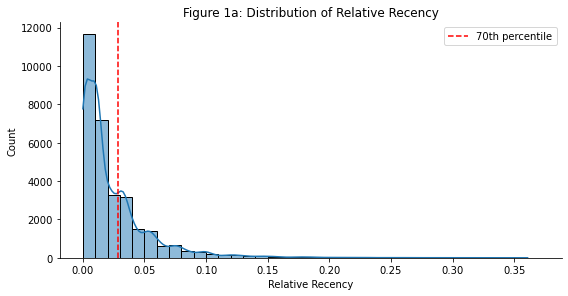

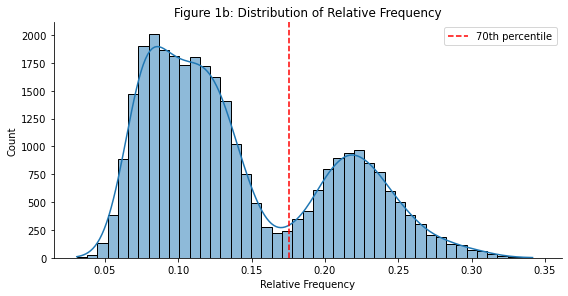

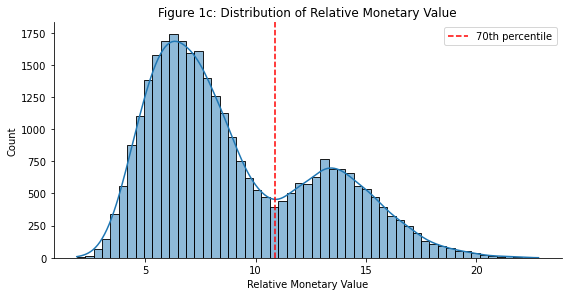

In [5]:
# Plot RFM distributions
sns.displot(agg_customer_data['RelativeRecency'], binwidth = 0.01, kde=True, height=4, aspect=2)
plt.axvline(x=agg_customer_data.RelativeRecency.quantile(0.7), label='70th percentile', color='r', linestyle='--')
plt.title('Figure 1a: Distribution of Relative Recency')
plt.xlabel('Relative Recency')
plt.legend()

sns.displot(agg_customer_data['RelativeFrequency'], binwidth = 0.007, kde=True, height=4, aspect=2)
plt.axvline(x=agg_customer_data.RelativeFrequency.quantile(0.7), label='70th percentile', color='r', linestyle='--')
plt.title('Figure 1b: Distribution of Relative Frequency')
plt.xlabel('Relative Frequency')
plt.legend()

sns.displot(agg_customer_data['RelativeMonetary'].astype(float), kde=True, height=4, aspect=2)
plt.axvline(x=agg_customer_data.RelativeMonetary.quantile(0.7), label='70th percentile', color='r', linestyle='--')
plt.title('Figure 1c: Distribution of Relative Monetary Value')
plt.xlabel('Relative Monetary Value')
plt.legend()

plt.show()

### Divide Customers into Customer Segments
I divided customers into customer segments by assigning the following classifications:
* **High value customers** - customers with:
    * relative recency <= 70th percentile value of relative recency distribution (note that lower recency value means more recent)
    * relative frequency > 70th percentile value of relative frequency distribution
    * relative monetary value > 70th percentile value of relative monetary value distribution
* **Medium value customers** - customers with:
    * relative recency > 70th percentile value of relative recency distribution
    * relative frequency <= 70th percentile value of relative frequency distribution
    * relative monetary value <= 70th percentile value of relative monetary value distribution
* **Low value customers** - customers with relative RFM values that don’t meet the threshold for high and medium value customers

Figure 2 shows the division of all customers who purchased something in 2020 into customer segments based on the relative RFM model.


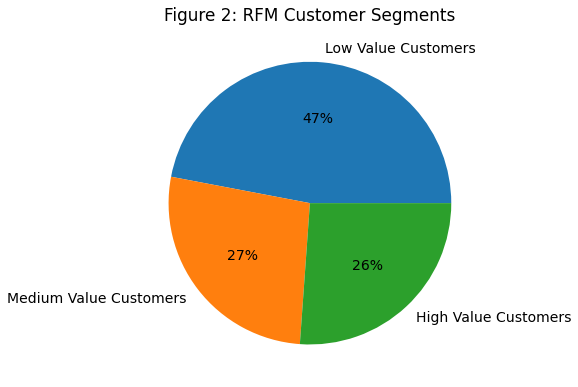

In [6]:
# define rfm threshold values for high, med, and low
r_limit = agg_customer_data.RelativeRecency.quantile(0.7)
f_limit = agg_customer_data.RelativeFrequency.quantile(0.7)
m_limit = agg_customer_data.RelativeMonetary.quantile(0.7)

# define conditions for segmenting customers
high_condition = (agg_customer_data['RelativeRecency'] <= r_limit) & (agg_customer_data['RelativeFrequency'] > f_limit) & (agg_customer_data['RelativeMonetary'] > m_limit)
low_condition = (agg_customer_data['RelativeRecency'] > r_limit) & (agg_customer_data['RelativeFrequency'] <= f_limit) & (agg_customer_data['RelativeMonetary'] <= m_limit)

# segment customers into rfm categories: low value, medium value, high value, and top value
agg_customer_data_labelled = agg_customer_data.copy()
agg_customer_data_labelled['customer_segment'] = np.where(high_condition, 'High Value Customers',
                np.where(low_condition,'Medium Value Customers', 'Low Value Customers'))

# plot customer segments
plt.figure(figsize=(6.5,6.5))
plt.rcParams['font.size'] = 14
plt.title('Figure 2: RFM Customer Segments')
plt.pie(agg_customer_data_labelled.customer_segment.value_counts(),
        labels=agg_customer_data_labelled.customer_segment.value_counts().index,
        autopct='%.0f%%')
plt.show()

In [7]:
print('r_limit: ' + str(r_limit))
print('f_limit: ' + str(f_limit))
print('m_limit: ' + str(m_limit))

r_limit: 0.02857142857142857
f_limit: 0.17582417582417584
m_limit: 10.893468356060726


### Conclusion
The best customer model I proposed assigns customers to the following customer segments according to the following criteria:

* **High value customers** - customers with:
    * relative recency <= 0.02857142857142857 (note that lower recency value means more recent)
    * relative frequency > 0.17582417582417584
    * relative monetary value > 10.893468356060726
* **Medium value customers** - customers with:
    * relative recency > 0.02857142857142857
    * relative frequency <= 0.17582417582417584
    * relative monetary value <= 10.893468356060726
* **Low value customers** - customers with relative RFM values that don’t meet the threshold for high and medium value customers

The RFM model that adjusts for customer lifetime bias is an appropriate model for determining what a best customer is by AGM standards. It's appropriate for our dataset because it segments our customers into reasonable proportions. The model reflects recency, frequency, and monetary patterns that provide a good starting point for further understanding AGM customer behavior.